# Th1/Th2 polarization signature

Data source: 
- Ota et al., Cell 2021 
- [Hollbacher et al., Immunohorizons 2021](https://academic.oup.com/immunohorizons/article/4/10/585/7820541?login=true)
- in-house Diff043 scRNAseq

In [1]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

from scipy.stats import pearsonr

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

To download processed data on dropbox:
```bash
DATADIR=/mnt/oak/users/emma/data/GWT/polarization_datasets/
mkdir -p $DATADIR

# Ron scRNA-seq
DROPBOX_PATH=GRNPerturbSeq/3_expts/Diff035scRNAseq/
rclone copy dropbox:${DROPBOX_PATH}Diff035_pseudobulk.h5ad ${DATADIR} --checksum --ignore-times
rclone copy dropbox:${DROPBOX_PATH}Diff035_merged.gex.filtered.h5ad ${DATADIR} --checksum --ignore-times

# Published datasets
DROPBOX_PATH=GRNPerturbSeq/2_files/
rclone copy dropbox:${DROPBOX_PATH}Ota_et_al_2021/ ${DATADIR}Ota_et_al_2021 --checksum --ignore-times -v
mkdir -p $DATADIR/Hollbacher_et_al_2021
rclone copy dropbox:${DROPBOX_PATH}Hollbacher_et_al_2021/ $DATADIR/Hollbacher_et_al_2021/ --checksum --ignore-times -v
```

### Process Hollbacher et al 2021 RNAseq

In [3]:
DATADIR = '/mnt/oak/users/emma/data/GWT/polarization_datasets/'

In [3]:
hollbacher_df = pd.read_csv(f'{DATADIR}/Hollbacher_et_al_2021/Hollbacher_et_al_raw_counts.csv', index_col=0)

In [5]:
# Parse into anndata in preparation for DESeq2
obs_metadata = pd.DataFrame({'donor_id': [item[0] for item in hollbacher_df.columns.str.split('_')],
                            'cell_subset': [item[1] for item in hollbacher_df.columns.str.split('_')]},
                            index=hollbacher_df.columns)
adata_hollbacher = anndata.AnnData(X=hollbacher_df.T.astype(int),
                                   obs=obs_metadata,
                                   var=pd.DataFrame({'gene_name': hollbacher_df.index},
                                                     index=hollbacher_df.index))
adata_hollbacher.var['mean_expression'] = adata_hollbacher.X.mean(axis=0)
#adata_hollbacher = adata_hollbacher[:, adata_hollbacher.var['mean_expression'] > 10].copy()

In [10]:
adata_hollbacher.obs.donor_id.nunique()

3

In [5]:
sc.pp.pca(adata_hollbacher)
pcs = adata_hollbacher.obsm['X_pca'][:,:10]
pc_df = pd.DataFrame(pcs,
                     index=adata_hollbacher.obs_names,
                     columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5',
                             'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
adata_hollbacher.obs = pd.concat([adata_hollbacher.obs, pc_df], axis=1)

In [6]:
adata_hollbacher.obs.cell_subset.unique()

array(['Th17', 'Th22', 'Th2', 'Th1/17', 'Th1', 'Naive', 'Treg17',
       'Treg22', 'Treg2', 'Treg1/17', 'Treg1'], dtype=object)

In [7]:
model = pertpy.tl.PyDESeq2(adata_hollbacher, design='~cell_subset+donor_id+PC1')
model.fit(quiet=True)

# Create a list to store all result dataframes
result_dfs = []

for subset in ['Th2']:
    test_st = subset
    control_st = 'Th1'
    polariz_contrast = (model.cond(cell_subset=test_st) - model.cond(cell_subset=control_st)) 
    res_df = model.test_contrasts(polariz_contrast)
    res_df['contrast'] = test_st + '_vs_' + control_st
    # Store the result dataframe in our list
    result_dfs.append(res_df)

all_results_hollbacher_df = pd.concat(result_dfs)

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:380: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:234: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:232: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:384: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:387: RuntimeWarning: invalid value encountered in divide
  + ((1 / disp + counts) * mu_ / (1 / disp +

Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
                                                                           
A1BG      60.401506        0.690717  0.268060  2.576725  0.009974  0.145776
AAAS     236.956091       -0.100342  0.142025 -0.706506  0.479874  0.907945
AACS     166.055195       -0.062094  0.161143 -0.385336  0.699988  0.967729
AAED1    290.132645        0.261344  0.227804  1.147233  0.251286  0.783194
AAGAB    417.375987       -0.074158  0.099946 -0.741986  0.458096  0.898734
...             ...             ...       ...       ...       ...       ...
ZYG11A     9.088249       -0.256005  0.579211 -0.441988  0.658498  0.962136
ZYG11B   502.647468        0.012023  0.132184  0.090956  0.927528  0.998439
ZYX     2269.454502        0.505421  0.155465  3.251029  0.001150  0.029706
ZZEF1   2934.792766       -0.041094  0.138004 -0.29

... done in 0.79 seconds.



In [8]:
all_results_hollbacher_df[all_results_hollbacher_df.variable=='IFNGR2']

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
61,IFNGR2,219.236197,1.496207,0.232109,6.446138,1.147362e-10,2.307123e-08,Th2_vs_Th1


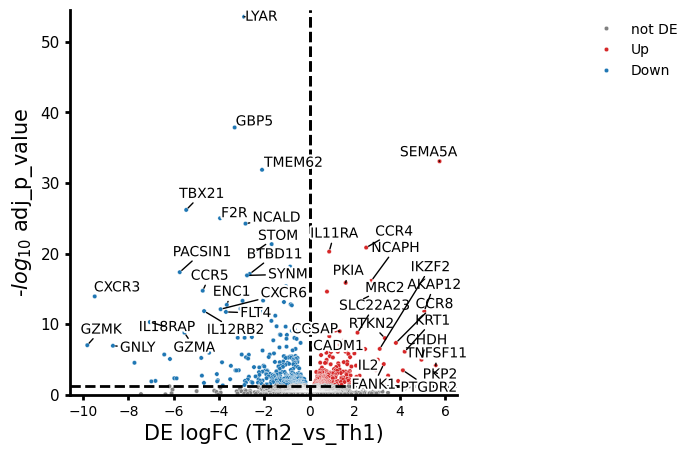

In [10]:
res_df = all_results_hollbacher_df[all_results_hollbacher_df.contrast=='Th2_vs_Th1'].copy()
p = res_df['contrast'].iloc[0]
model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    s=10,
    x_label=f"DE logFC ({p})",
    to_label = 20,
    )

In [11]:
all_results_hollbacher_df['zscore'] = all_results_hollbacher_df['log_fc'] / all_results_hollbacher_df['lfcSE']
all_results_hollbacher_df.to_csv("results/hollbacher_Th2vsTh1_DE_results.csv", index=False)

### Process Ota et al 2021 RNAseq

In [12]:
# Load sample information, memory CD4, Th1 and Th2 RNAseq
sample_info = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/clinical_diagnosis_age_sex_v2.txt', delimiter='\t')
ota_Th1 = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Th1_count.txt', delimiter='\t')
ota_Th2 = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Th2_count.txt', delimiter='\t')
ota_naive = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Naive_CD4_count.txt', delimiter='\t')
ota_mem = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Mem_CD4_count.txt', delimiter='\t')
ota_Th17 = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Th17_count.txt', delimiter='\t')
ota_Tfh = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Tfh_count.txt', delimiter='\t')
ota_all = [ota_Th1, ota_Th2, ota_naive, ota_mem, ota_Th17, ota_Tfh]

# Select phase 2 healthy control samples
mask = (sample_info.disease=='HC') & (sample_info.Phase==2)
sample_HC_p2 = sample_info[mask].id.values
sample_common = set(sample_HC_p2)

# Find common samples across all subsets
for sample in ota_all:
    sample_common = sample_common & set(sample.columns)

sample_common = list(sample_common)
columns_to_get = ['Gene_id', 'Gene_name'] + sample_common

for i, sample in enumerate(ota_all):
    ota_all[i] = sample[columns_to_get].copy()

# Parse into anndata in preparation for DESeq2
cell_subset = ['Th1', 'Th2', 'naive', 'memory', 'Th17', 'Tfh']
obs_metadata = pd.DataFrame({'cell_subset': cell_subset[0],
                             'donor_id': ota_all[0].columns[2:]},
                            index=cell_subset[0]+'_'+ota_all[0].columns[2:])
adata_ota = anndata.AnnData(X=ota_all[0].iloc[:,2:].T.reset_index(drop=True),
                            obs=obs_metadata,
                            var=ota_all[0].iloc[:,:2])

for i, sample in enumerate(ota_all[1:]):
    obs_metadata = pd.DataFrame({'cell_subset': cell_subset[i+1],
                                 'donor_id':sample.columns[2:]},
                                index=cell_subset[i+1]+'_'+sample.columns[2:])
    adata_temp = anndata.AnnData(X=sample.iloc[:,2:].T.reset_index(drop=True),
                                obs=obs_metadata,
                                var=sample.iloc[:,:2])
    adata_ota = ad.concat([adata_ota, adata_temp])

adata_ota.var = ota_all[0].iloc[:,:2].copy()
adata_ota.var.index = adata_ota.var['Gene_name']
adata_ota.var_names_make_unique()
obs_temp = adata_ota.obs.copy()
obs_update = pd.merge(obs_temp, sample_info, how='inner', left_on='donor_id', right_on='id')
obs_update = obs_update[['cell_subset', 'donor_id', 'age', 'sex']]
obs_update.index = adata_ota.obs.index
adata_ota.obs = obs_update.copy()
sc.pp.filter_genes(adata_ota, min_counts=100)

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:268: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3', 'SNORD113-5', 'SNORD113-6']
  warnings.warn(


In [13]:
sc.pp.pca(adata_ota)
pcs = adata_ota.obsm['X_pca'][:,:10]
pc_df = pd.DataFrame(pcs,
                     index=adata_ota.obs_names,
                     columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5',
                             'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
adata_ota.obs = pd.concat([adata_ota.obs, pc_df], axis=1)

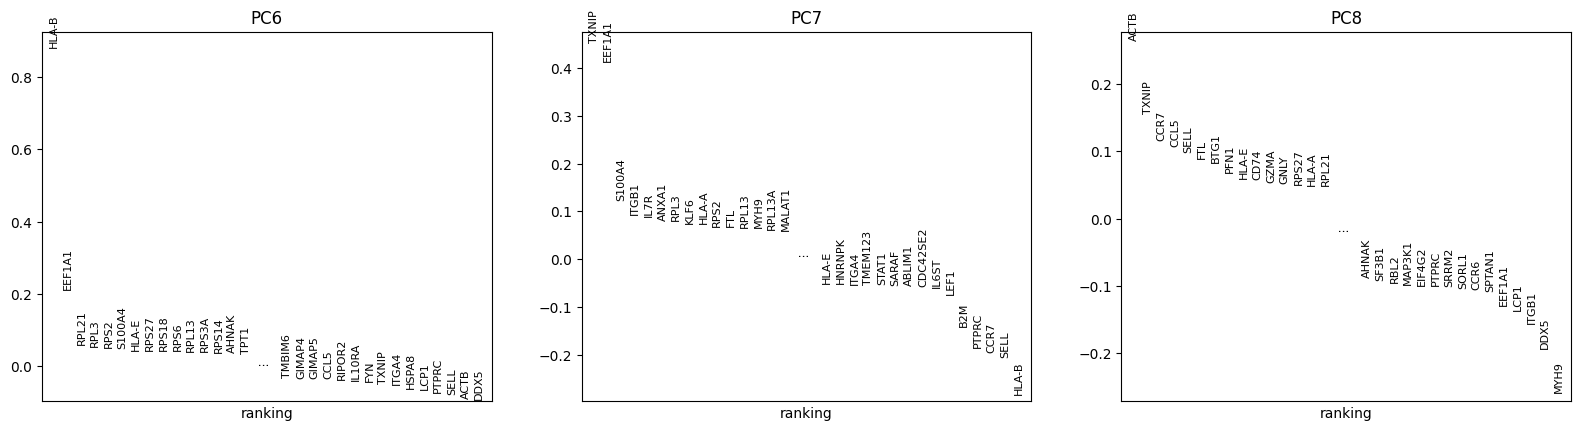

In [14]:
sc.pl.pca_loadings(adata_ota, components='6,7,8')

In [17]:
# flex_gene_df = pd.read_csv(f'{DATADIR}/Chromium_Human_Transcriptome_Probe_Set_v1.1.0_GRCh38-2024-A_notitle.csv')
# flex_gene = flex_gene_df[flex_gene_df.included==True].gene_name.unique()
# len(flex_gene), len(set(flex_gene)&set(adata_ota.var.Gene_name.values)), len(set(adata_ota.var.Gene_name.values))

In [18]:
adata_ota.obs.cell_subset.unique()

array(['Th1', 'Th2', 'naive', 'memory', 'Th17', 'Tfh'], dtype=object)

In [77]:
adata_ota

AnnData object with n_obs × n_vars = 378 × 24821
    obs: 'cell_subset', 'donor_id', 'age', 'sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'size_factors', 'replaceable'
    var: 'Gene_id', 'Gene_name', 'n_counts', '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    uns: 'pca', 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'X_pca', 'design_matrix', '_mu_LFC', '_hat_diagonals'
    varm: 'PCs', 'LFC'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [19]:
model = pertpy.tl.PyDESeq2(adata_ota, design='~cell_subset+PC1+PC2')
model.fit(quiet=True)

# Create a list to store all result dataframes
result_dfs = []

for subset in ['Th2']:
    test_st = subset
    control_st = 'Th1'
    polariz_contrast = (model.cond(cell_subset=test_st) - model.cond(cell_subset=control_st)) 
    res_df = model.test_contrasts(polariz_contrast)
    res_df['contrast'] = test_st + '_vs_' + control_st
    # Store the result dataframe in our list
    result_dfs.append(res_df)

all_results_ota_df = pd.concat(result_dfs)

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:380: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:234: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:232: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:384: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:387: RuntimeWarning: invalid value encountered in divide
  + ((1 / disp + counts) * mu_ / (1 / disp +

Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  1.  0.  0.  0.  0.]
              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
Gene_name                                                                   
DPM1        509.149188        0.053026  0.027243   1.946422  5.160406e-02   
SCYL3       452.920560        0.069168  0.030484   2.268944  2.327175e-02   
C1orf112     91.382905        0.185970  0.057860   3.214144  1.308340e-03   
FGR         101.401593       -4.884158  0.316217 -15.445584  8.079304e-54   
CFH         191.970461       -2.292555  0.376881  -6.082969  1.179772e-09   
...                ...             ...       ...        ...           ...   
AC099063.4   81.240089       -0.492712  0.048895 -10.076984  6.983703e-24   
AL139424.3    2.159751       -0.235192  0.218795  -1.074942  2.824008e-01   
AL358472.5    7.220517       -0.144415  0.125580  -1.149985  2.501500e-01   
AL645728.2    0.441464       -0.124228  0.462413  -0.268651  7.8

... done in 1.35 seconds.



NaNs encountered, dropping rows with NaNs
0s encountered for p value, replacing with 1e-323


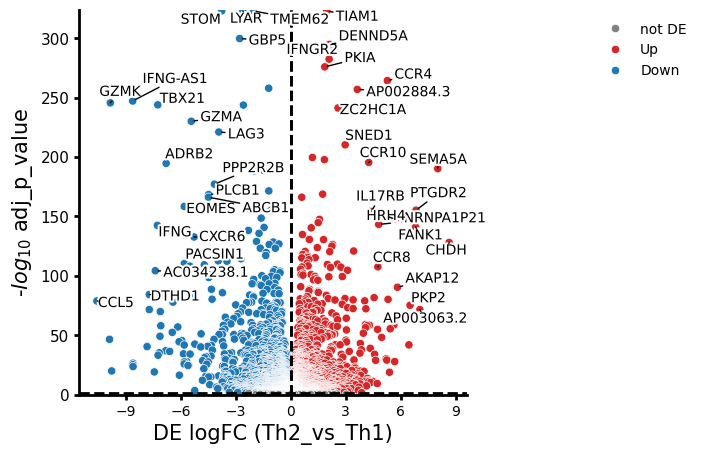

In [24]:
res_df = all_results_ota_df[all_results_ota_df.contrast=='Th2_vs_Th1'].copy()
p = res_df['contrast'].iloc[0]
model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    x_label=f"DE logFC ({p})",
    to_label = 20
    )

In [27]:
all_results_ota_df['zscore'] = all_results_ota_df['log_fc']/all_results_ota_df['lfcSE']
all_results_ota_df.to_csv("results/Ota_Th2vsTh1_DE_results.csv", index=False)

## DE analysis on polarization experiments

In [2]:
all_results_diff043_df = pd.read_csv("results/Diff043_Th2vsTh1_DE_results.csv")
all_results_ota_df = pd.read_csv("results/Ota_Th2vsTh1_DE_results.csv")
all_results_hollbacher_df = pd.read_csv("results/hollbacher_Th2vsTh1_DE_results.csv")

In [3]:
activation_signature = pd.read_csv('Arce2024_20230130_DESeq2_output_AAVS1_Teff_Stimulation_vs_Resting.csv').dropna()
activation_signature = activation_signature.rename(columns={'log2FoldChange':'log_fc', 'padj':'adj_p_value', 'gene_name':'variable'})
activation_signature['zscore'] = activation_signature['log_fc']/activation_signature['lfcSE']

/tmp/ipykernel_3070211/1013178896.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['log_fc_plot'] = selected['log_fc'].clip(-log_fc_cap, log_fc_cap)
/tmp/ipykernel_3070211/1013178896.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['neglog10_fdr_plot'] = neglog10_fdr_sel.clip(upper=log10_fdr_cap)


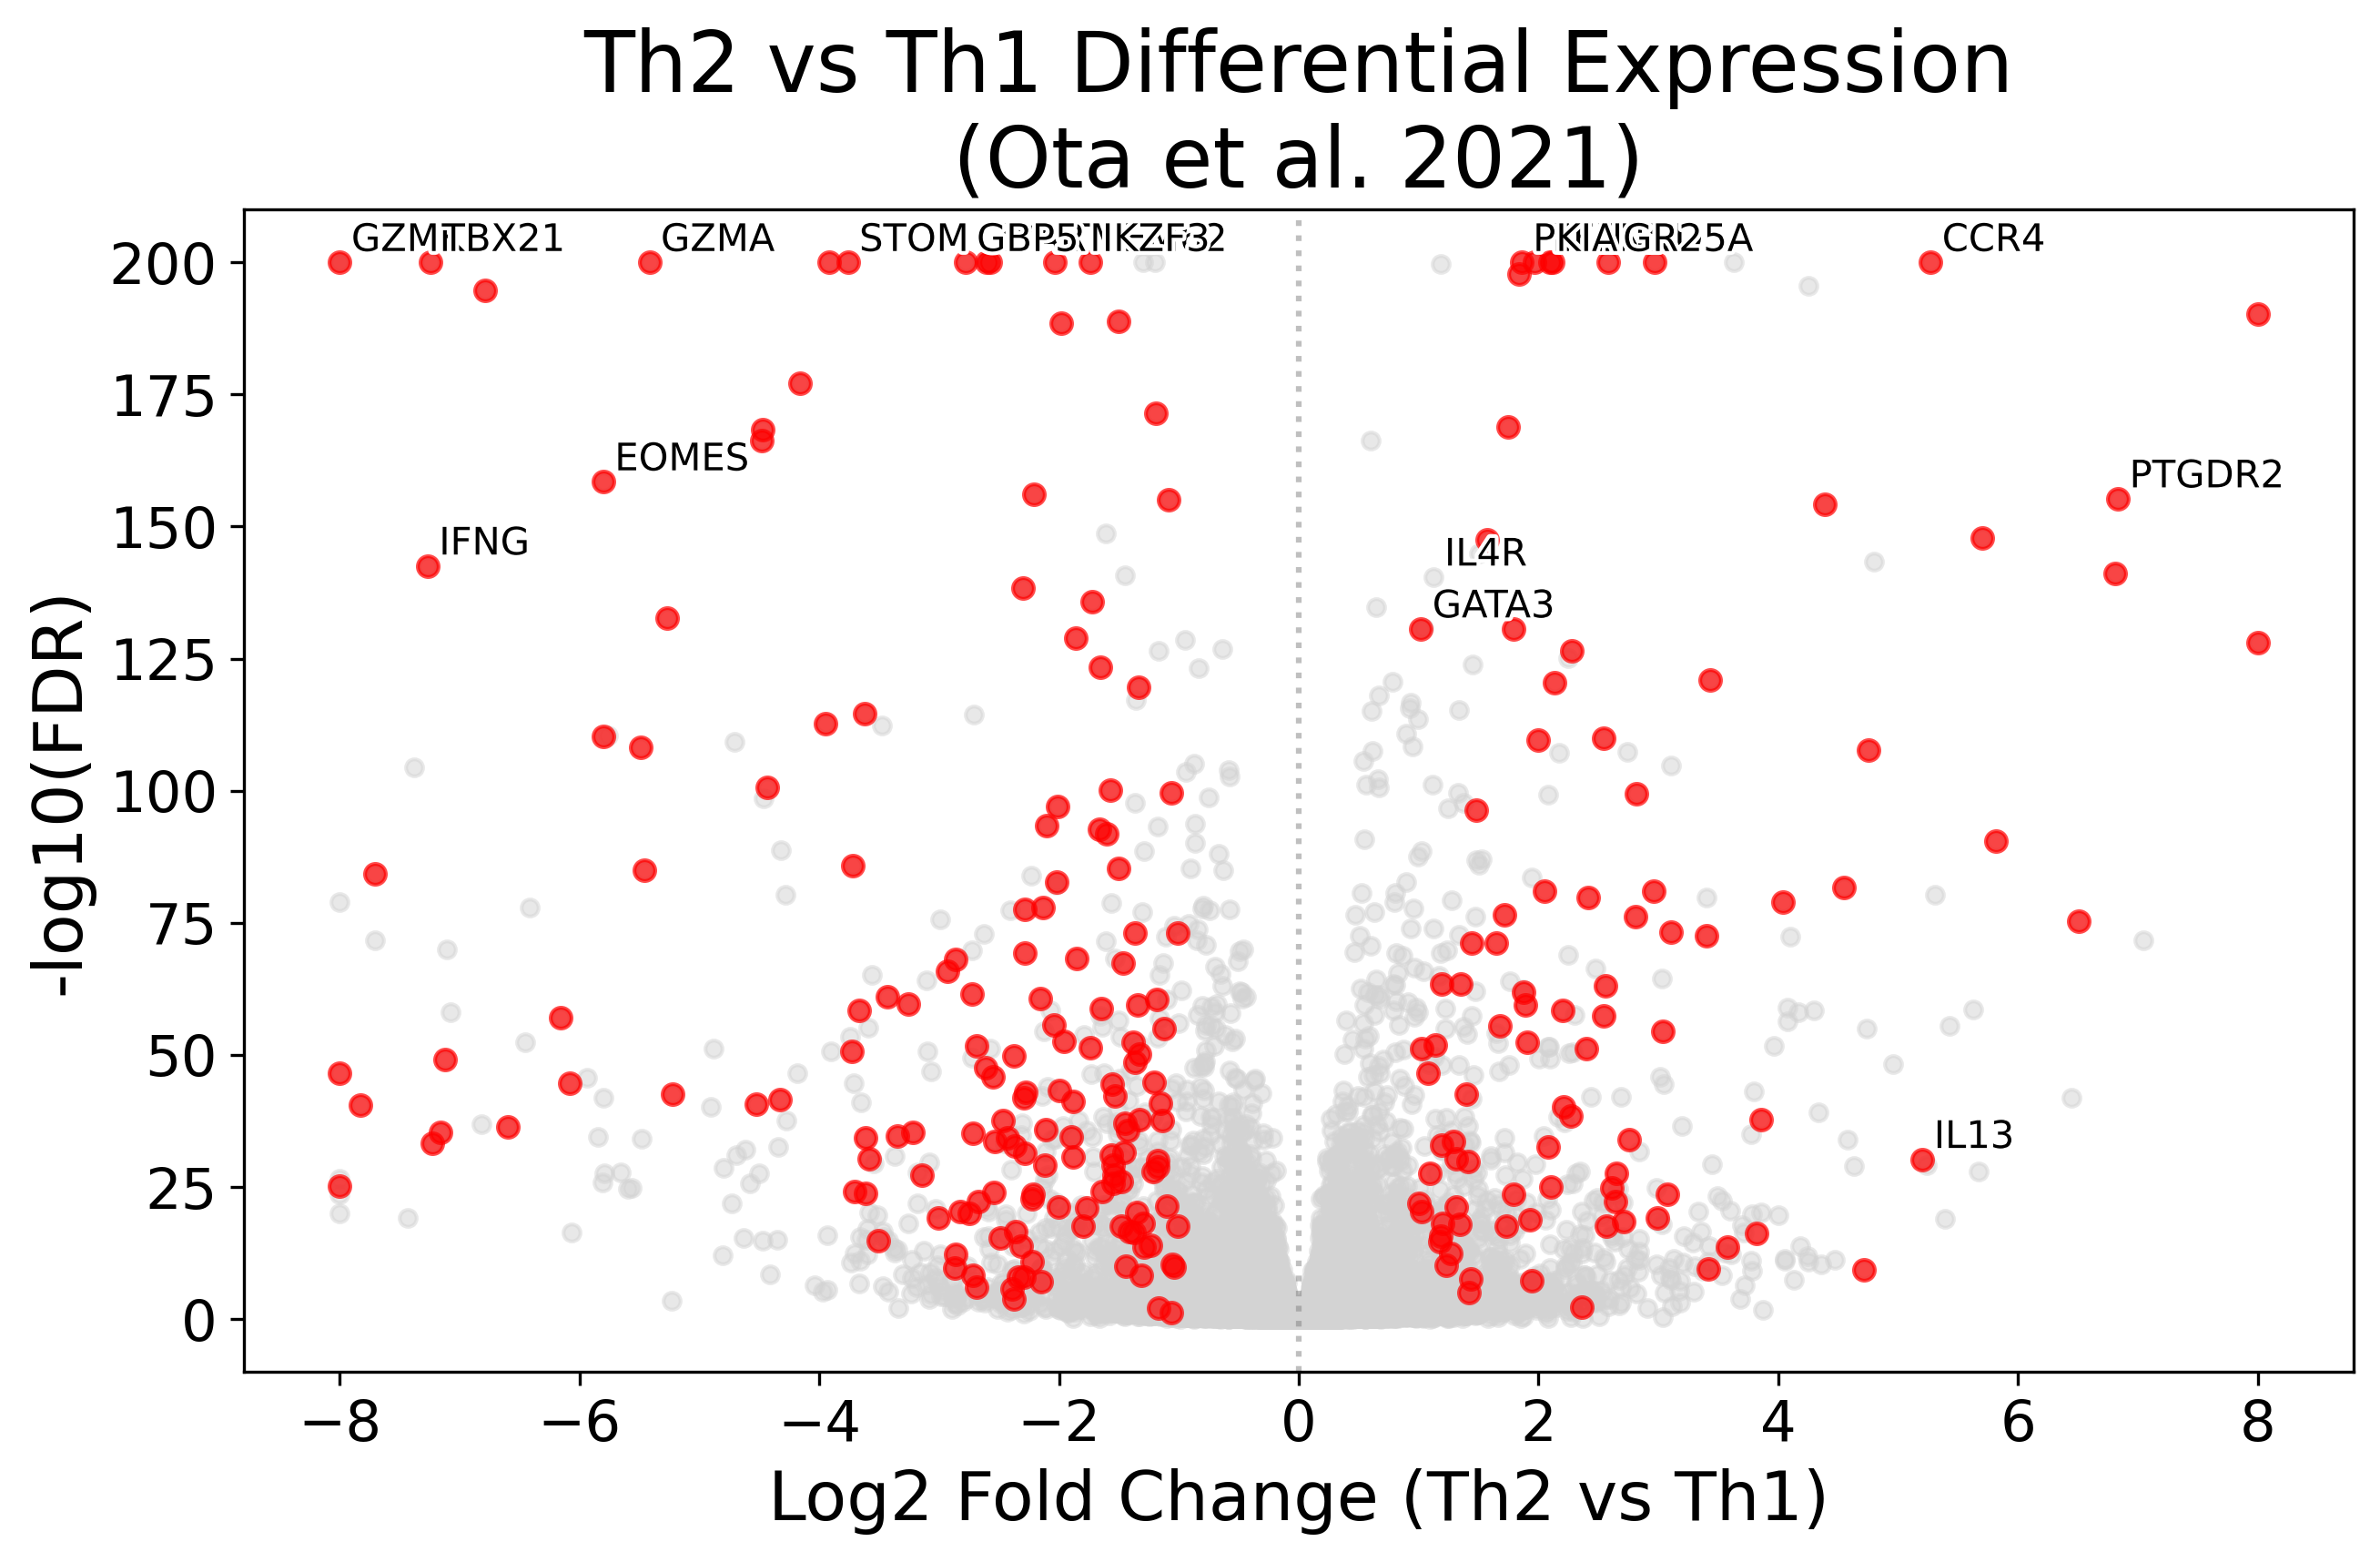

In [10]:
signif_thres = 1
log10_fdr_cap = 200
log_fc_cap = 8

test = all_results_ota_df[all_results_ota_df.adj_p_value <= signif_thres].copy()

# Calculate capped columns for plotting
test['log_fc_plot'] = test['log_fc'].clip(-log_fc_cap, log_fc_cap)
neglog10_fdr = -np.log10(test['adj_p_value'].replace(0, np.nextafter(0, 1)))
test['neglog10_fdr_plot'] = neglog10_fdr.clip(upper=log10_fdr_cap)

plt.figure(figsize=(9,6))

# Plot all points in grey
plt.scatter(test['log_fc_plot'], test['neglog10_fdr_plot'],
           color='lightgrey', alpha=0.5, s=20, rasterized=False)

# Highlight points significant in both cohorts
test_both = pd.merge(
    test,
    all_results_hollbacher_df[['variable', 'adj_p_value', 'log_fc']],
    on='variable'
).copy()
test_both['log_fc_x_plot'] = test_both['log_fc_x'].clip(-log_fc_cap, log_fc_cap)
test_both['neglog10_fdr_x_plot'] = (-np.log10(
    test_both['adj_p_value_x'].replace(0, np.nextafter(0, 1))
)).clip(upper=log10_fdr_cap)

signif_both = (
    (test_both['adj_p_value_x'] < 0.1) &
    (test_both['adj_p_value_y'] < 0.1) &
    (abs(test_both['log_fc_x']) > 1) &
    (abs(test_both['log_fc_y']) > 1)
)
plt.scatter(
    test_both.loc[signif_both, 'log_fc_x_plot'],
    test_both.loc[signif_both, 'neglog10_fdr_x_plot'],
    color='red', alpha=0.7, s=30, label='Signif. across cohorts', rasterized=False
)

# Get top/bottom genes by total effect among genes significant in both datasets
n_top = 10
test_both['total_effect'] = test_both['neglog10_fdr_x_plot']
top_genes = test_both[signif_both].nlargest(n_top, 'total_effect')
# bottom_genes = test_both[signif_both].nsmallest(n_top, 'total_effect')

# Add selected genes to annotate
selected_genes = ['GZMA', 'GZMK','TBX21', 'GATA3', 'IL4R', 'EOMES', 'FOXP3', 'IFNG', 'PTGDR2','IL13']
selected = test[test['variable'].isin(selected_genes + top_genes['variable'].tolist())]

# Prepare for annotation (capped values)
selected['log_fc_plot'] = selected['log_fc'].clip(-log_fc_cap, log_fc_cap)
neglog10_fdr_sel = -np.log10(selected['adj_p_value'].replace(0, np.nextafter(0, 1)))
selected['neglog10_fdr_plot'] = neglog10_fdr_sel.clip(upper=log10_fdr_cap)

# Annotate genes with adjust_text to avoid overlaps
texts = []
for _, gene in selected.iterrows():
    texts.append(plt.annotate(
        gene['variable'],
        xy=(gene['log_fc_plot'], gene['neglog10_fdr_plot']),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=10,
        path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=2, foreground='white')]
    ))

# Add dotted lines at significance thresholds
# plt.axhline(y=-np.log10(0.1), color='grey', linestyle=':', alpha=0.5)
plt.axvline(x=0, color='grey', linestyle=':', alpha=0.5)
# plt.axvline(x=1, color='grey', linestyle=':', alpha=0.5)

# Add labels
plt.xlabel('Log2 Fold Change (Th2 vs Th1)', fontsize=18)
plt.ylabel('-log10(FDR)', fontsize=18)
plt.title('Th2 vs Th1 Differential Expression\n(Ota et al. 2021)', fontsize=22)
plt.legend([], frameon=False)

plt.tight_layout()
plt.savefig('./results/Ota_volcano_plot.pdf')
plt.savefig('./results/Ota_volcano_plot.png')

## Comparison of polarization signatures

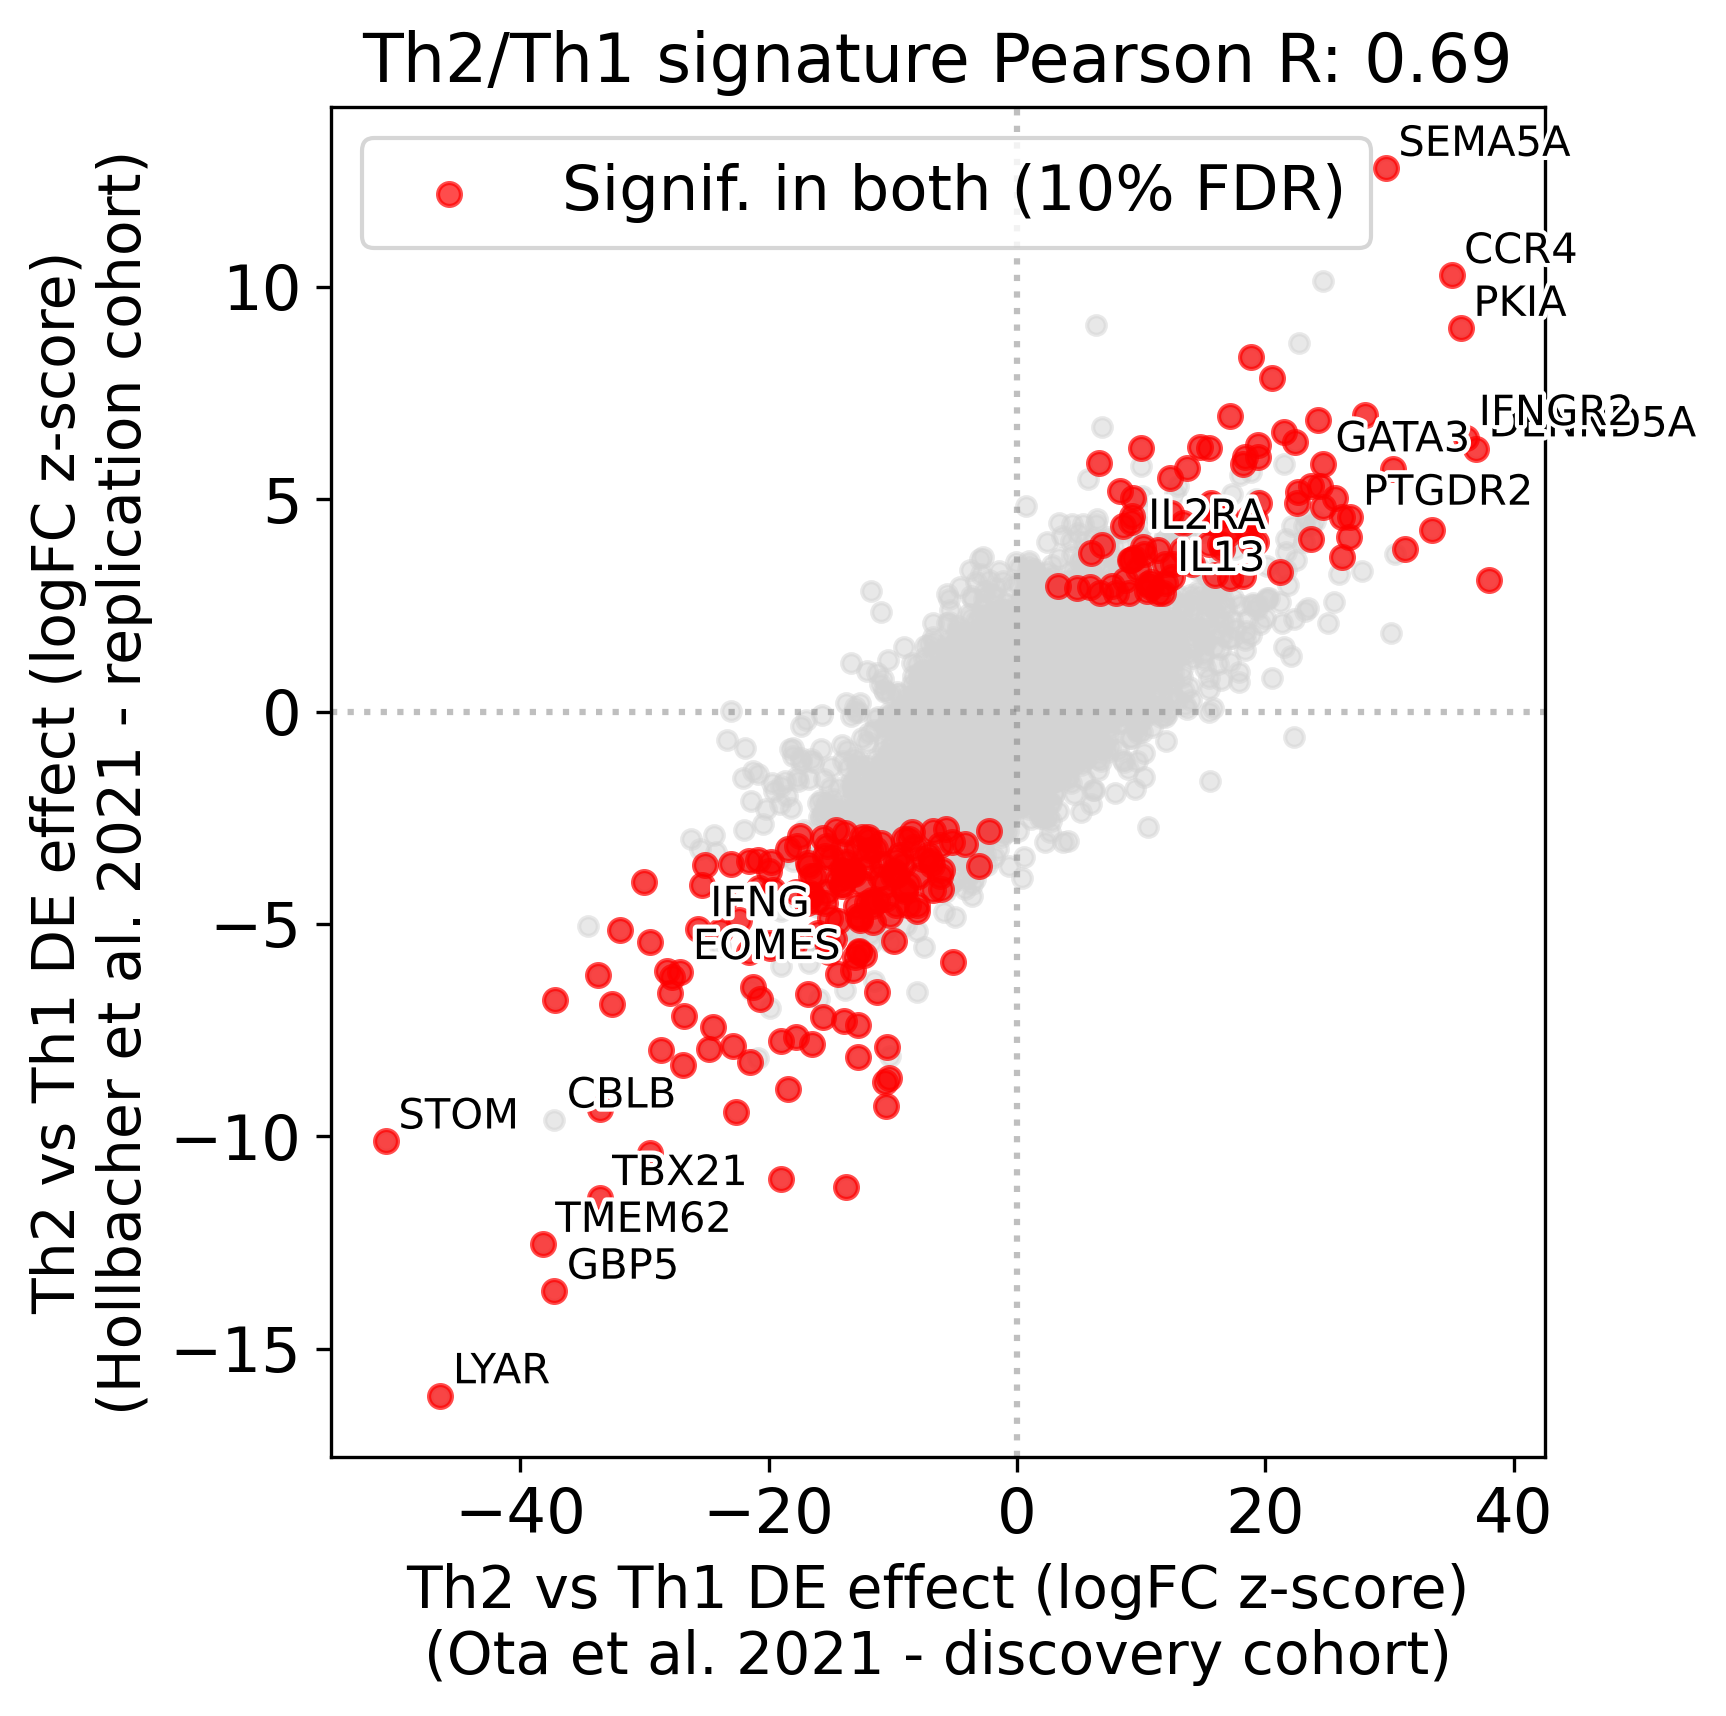

In [7]:
signif_thres = 1
test = pd.merge(all_results_ota_df[all_results_ota_df.adj_p_value<=signif_thres][['variable', 'zscore', 'log_fc', 'adj_p_value']],
                all_results_hollbacher_df[['variable', 'zscore', 'log_fc', 'adj_p_value']],
                left_on='variable',
                right_on='variable')
test = test.fillna(0)
test

plt.figure(figsize=(6,6))

# Plot all points in grey
plt.scatter(test['zscore_x'], test['zscore_y'], color='lightgrey', alpha=0.5, s=20, rasterized=True)

# Add points significant in both datasets
signif_both = (test['adj_p_value_x'] < 0.1) & (test['adj_p_value_y'] < 0.1) & (abs(test['log_fc_x']) > 1) & (abs(test['log_fc_y']) > 1)
plt.scatter(test.loc[signif_both, 'zscore_x'], test.loc[signif_both, 'zscore_y'],
           color='red', alpha=0.7, s=30, label='Signif. in both (10% FDR)', rasterized=True)

# Get top/bottom genes by total zscore
n_top = 5
test['total_zscore'] = test['zscore_x'] + test['zscore_y']
top_genes = test.nlargest(n_top, 'total_zscore')
bottom_genes = test.nsmallest(n_top, 'total_zscore')
# Add selected genes to annotate
selected_genes = ['TBX21', 'GATA3', 'EOMES', 'FOXP3', 'IL2RA', 'IFNG', 'IL4', 'PTGDR2','IL13', 'IL5']
selected = test[test['variable'].isin(selected_genes)]
# plt.scatter(selected['zscore_x'], selected['zscore_y'], 
#            color='blue', alpha=0.7, s=50, label='Selected genes')

# Annotate these genes with adjust_text to avoid overlaps
texts = []
for _, gene in pd.concat([top_genes, bottom_genes, selected]).iterrows():
    texts.append(plt.annotate(gene['variable'],
                xy=(gene['zscore_x'], gene['zscore_y']),
                xytext=(3, 3),
                textcoords='offset points',
                fontsize=10,
                path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=2, foreground='white')]))

# Add dotted lines at x=0 and y=0
plt.axhline(y=0, color='grey', linestyle=':', alpha=0.5)
plt.axvline(x=0, color='grey', linestyle=':', alpha=0.5)

# Add labels
plt.xlabel('Th2 vs Th1 DE effect (logFC z-score)\n(Ota et al. 2021 - discovery cohort)', fontsize=14)
plt.ylabel('Th2 vs Th1 DE effect (logFC z-score)\n(Hollbacher et al. 2021 - replication cohort)', fontsize=14)
plt.legend()

# Calculate correlation and add to plot title
corr, pval = pearsonr(test['zscore_x'], test['zscore_y'])
plt.title(f'Th2/Th1 signature Pearson R: {corr:.2f}', fontsize=16)

plt.tight_layout()
plt.savefig('./results/Ota_vs_Hollbacher_signature.pdf')
plt.savefig('./results/Ota_vs_Hollbacher_signature.png')

In [8]:
all_results_ota_df['contrast'] = 'Th2_vs_Th1 (Ota 2021)'
all_results_hollbacher_df['contrast'] = 'Th2_vs_Th1 (Hollbacker 2021)'

In [12]:
pd.concat([all_results_ota_df, all_results_hollbacher_df]).to_csv('../../metadata/suppl_tables/Th2_Th1_polarization_signature_DE_results_full.suppl_table.csv', index=False)